In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import math
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


In [2]:
from tqdm import tqdm

In [3]:
data_dir = 'data/inaturalist_12K/train'
test_data_dir = 'data/inaturalist_12K/val'

In [4]:
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

In [5]:

val_size = math.ceil(len(dataset)*0.2)
train_size = len(dataset) - val_size
train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 7999
Length of Validation Data : 2000


In [15]:
batch_size = 128
train_dl = DataLoader(train_data, batch_size, shuffle = True,num_workers=2, pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2)

In [62]:
# images, labels = next(iter(train_dl))
# images.size()

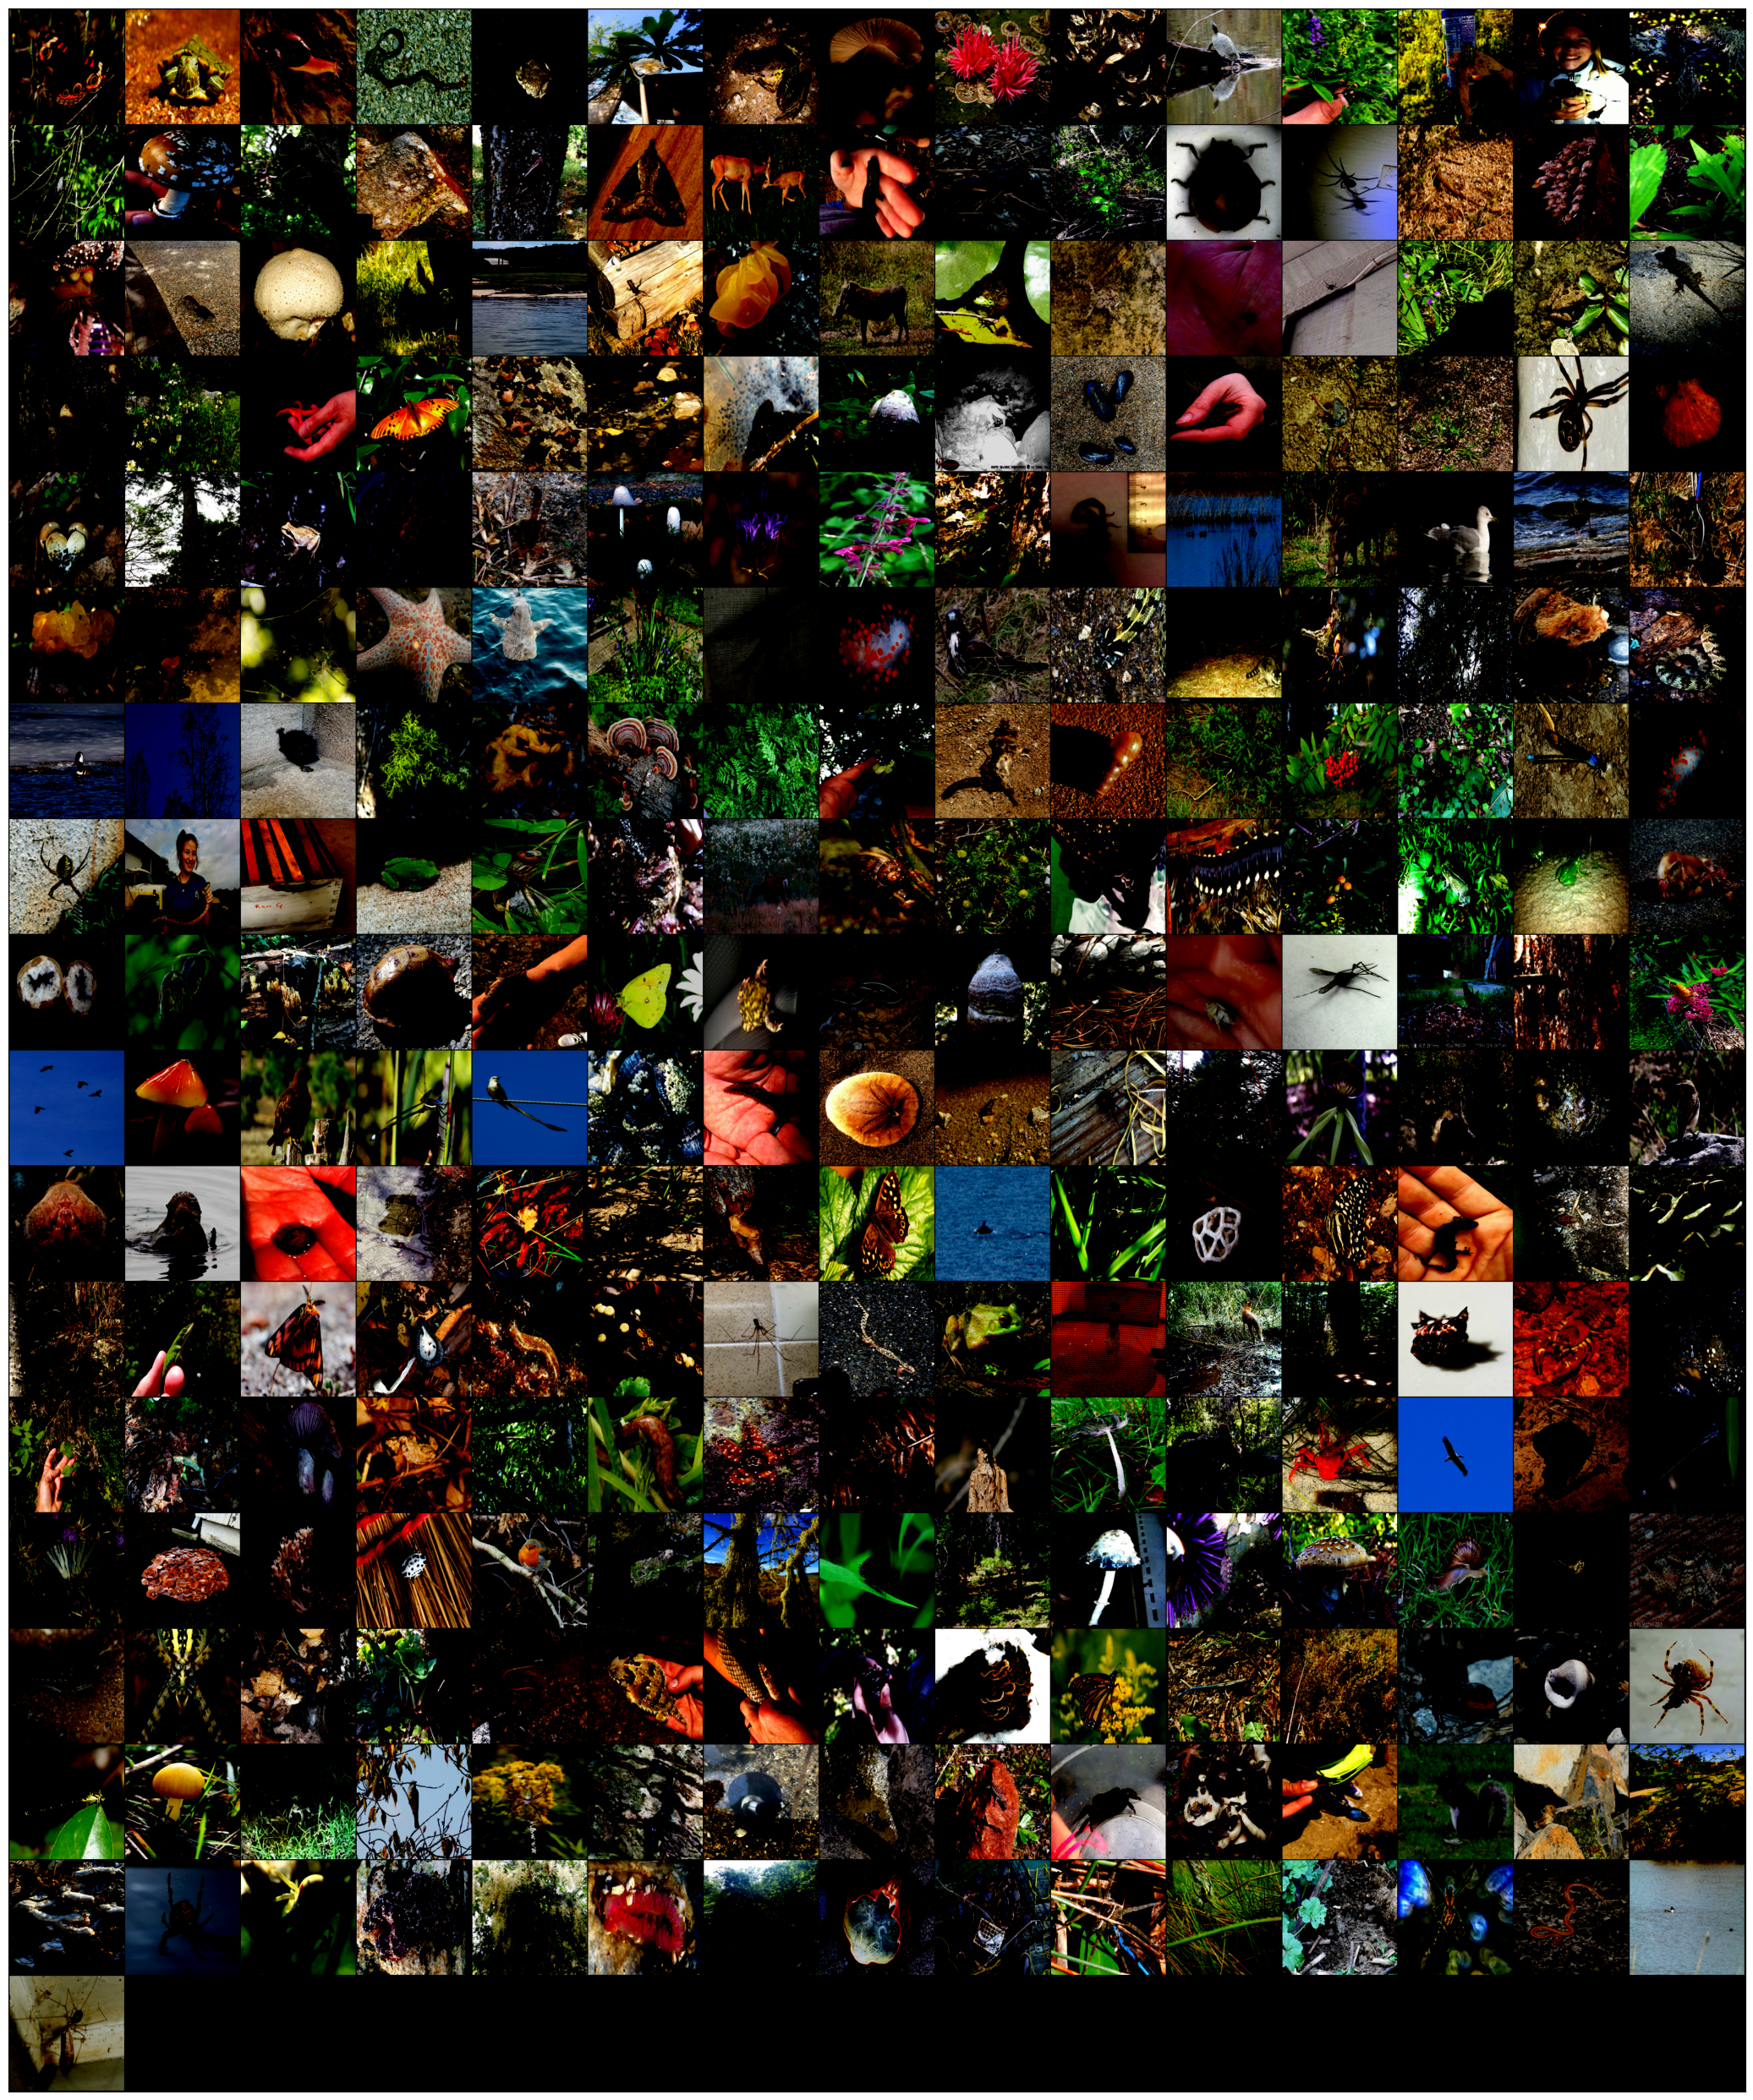

In [63]:
def images_batch(batches):
    for images,labels in batches:
        fig,ax = plt.subplots(figsize = (32,32))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow = 15).permute(1,2,0))
        break
images_batch(train_dl)

In [20]:
class CNNArchitecture(nn.Module):
    def __init__(self,param,h,w):
        super(CNNArchitecture,self).__init__()
        
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, param.filters[0], param.filterSize)
        if param.batchNormalization==True:
            self.batchnorm1 = nn.BatchNorm2d(param.filters[0])
        self.conv2 = nn.Conv2d(param.filters[0],param.filters[1],param.filterSize)
        if param.batchNormalization==True:
            self.batchnorm2 = nn.BatchNorm2d(param.filters[1])
        self.conv3 = nn.Conv2d(param.filters[1],param.filters[2],param.filterSize)
        if param.batchNormalization==True:
            self.batchnorm3 = nn.BatchNorm2d(param.filters[2])
        self.conv4 = nn.Conv2d(param.filters[2],param.filters[3],param.filterSize)
        if param.batchNormalization==True:
            self.batchnorm4 = nn.BatchNorm2d(param.filters[3])
        self.conv5 = nn.Conv2d(param.filters[3],param.filters[4],param.filterSize)
        if param.batchNormalization==True:
            self.batchnorm5 = nn.BatchNorm2d(param.filters[4])
        
        self.flatten_features =None
        #we need flatten features as an input for first dense layers without this our model will not be compatible
        # we are sending dummy image to our cnn layers and calculating what will be the parameters of it
        self.calculateFeatures(param,torch.rand(1,3,h,w))
        self.linearLayers = nn.ModuleList()

        #TODO: I didn't added activation layers here I have to do this work in forward pass
        if param.denseLayers!=0:
            self.linearLayers.append(nn.Linear(self.flatten_features,param.denseLayersSize))
            for _ in range(param.denseLayers-1):
                if int(param.dropout)!=0:
                    self.linearLayers.append(nn.Dropout(param.dropout))
                self.linearLayers.append(nn.Linear(param.denseLayersSize,param.denseLayersSize))
                
            self.linearLayers.append(nn.Linear(param.denseLayersSize,10))
        else:
            self.linearLayers.append(nn.Linear(param.flatten_features,10))

    def calculateFeatures(self,param,x):
        z = param.poolingSize
        activation = param.activation
        print(z)
        x = F.max_pool2d(activation(self.conv1(x)), z)
        print(x.size())
        x = F.max_pool2d(activation(self.conv2(x)), z)
        print(x.size())
        x = F.max_pool2d(activation(self.conv3(x)),z)
        print(x.size())
        x = F.max_pool2d(activation(self.conv4(x)),z)
        print(x.size())
        x = F.max_pool2d(activation(self.conv5(x)),z)
        print(x.size())
        self.flatten_features = x.size(1) * x.size(2) * x.size(3)
        
        
        
    def forward(self,param, x):
        z = param.poolingSize
        activation = param.activation
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(activation(self.conv1(x)), z)
        if param.batchNormalization==True:
            x = self.batchnorm1(x)
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(activation(self.conv2(x)), z)
        if param.batchNormalization == True:
            x = self.batchnorm2(x)
        x = F.max_pool2d(activation(self.conv3(x)),z)
        if param.batchNormalization == True:
            x = self.batchnorm3(x)
        x = F.max_pool2d(activation(self.conv4(x)),z)
        if param.batchNormalization == True:
            x = self.batchnorm4(x)
        x = F.max_pool2d(activation(self.conv5(x)),z)
        if param.batchNormalization == True:
            x = self.batchnorm5(x)
        
        
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension 
        for i in range(len(self.linearLayers)-1):
            x = activation(self.linearLayers[i](x))
        x = self.linearLayers[-1](x)
        return x

In [21]:
class Parameters:
    def __init__(self,filters,filter_size,pooling_size,stride,multiplier,dense_layers,dense_layer_size,aug,normalization,dropout,activation,optimizers):
        self.cnnLayers = 5
        self.filterMultiplier = multiplier# number float
        self.filters = self.settingFilters(filters,multiplier,self.cnnLayers)
        self.filterSize = filter_size
        self.poolingSize = pooling_size
        self.stride = stride
        self.denseLayers = dense_layers
        self.denseLayersSize = dense_layer_size
        self.dataAugmentation = aug
        self.batchNormalization = normalization# true or false
        self.dropout = dropout # probabilty
        self.activation_dict = { 'relu':F.relu,'selu':F.selu}
        self.optimzers_dict = {'sgd':optim.SGD,'nadam':optim.NAdam,"adam":optim.Adam,"rmsprop":optim.RMSprop}
        self.activation = self.activation_dict[activation]
        self.optimizer = self.optimzers_dict[optimizers]
        
    def settingFilters(self,filters,multiplier,layers):
        return [filters*(multiplier**i) for i in range(layers)]

In [36]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [18]:
device = get_default_device()
print(device)

cuda


**Sending Batches to GPU**

In [37]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

In [19]:
train_dl.device

AttributeError: 'DataLoader' object has no attribute 'device'

In [54]:
filters = 48 # filters are here represent number of filters in cnn 
filter_size = 5
pooling_size = 2
stride=2
multiplier = 2
dense_layers = 5
dense_size = 256
aug = False
normalization = True
dropout = 0.25
activation = 'relu'
optimizers = 'adam'
ob = Parameters(filters,filter_size,pooling_size,stride,multiplier,dense_layers,dense_size,aug,normalization,dropout,activation,optimizers)

In [25]:
img,labels = next(iter(train_dl))
h = img[0].size(1)
w = img[0].size(2)
print(h,w)

224 224


In [56]:
model = CNNArchitecture(ob,h,w)

2
torch.Size([1, 48, 110, 110])
torch.Size([1, 96, 53, 53])
torch.Size([1, 192, 24, 24])
torch.Size([1, 384, 10, 10])
torch.Size([1, 768, 3, 3])


***Sending model to gpu***

In [57]:
device_count = torch.cuda.device_count()
gpu_model = model
if device_count ==1:
    gpu_model = model.to(device)
elif device_count ==2:
    gpu_model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)

***Training model***

In [28]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [29]:
def evaluate(model, ob ,val_data, use_cuda = True):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_data:
            images, labels = data
            outputs = model.forward(ob,images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (100 * correct / total)

    
# this function will also work without gpu
def fit(ob,model,train_gpu,val_gpu,epochs):
    optimizer = ob.optimizer(model.parameters())
    history =[]
    for i in tqdm(range(epochs)):
        model.train()
        training_loss = []
        acc =[]
        for images, labels in train_gpu:
            optimizer.zero_grad()
            pred = model.forward(ob,images)
        
            loss = F.cross_entropy(pred, labels)
            training_loss.append(loss)
            loss.backward()
            optimizer.step()
        acc = evaluate(model,ob,val_gpu)
        #TODO : we have to calculate the accuracy and loss
        print("{} epoch have training loss = {:.5f}  validation accuracy = {:.5f}".format(i+1,torch.stack(training_loss).mean().item(),acc))
        
#         history.append()
            
            

In [58]:
fit(ob,gpu_model,train_dl,val_dl,50)

  2%|▏         | 1/50 [01:07<55:22, 67.80s/it]

1 epoch have training loss = 2.17287  validation accuracy = 18.90000


  4%|▍         | 2/50 [02:15<54:09, 67.70s/it]

2 epoch have training loss = 2.09519  validation accuracy = 24.15000


  6%|▌         | 3/50 [03:22<52:44, 67.33s/it]

3 epoch have training loss = 2.03899  validation accuracy = 27.45000


  6%|▌         | 3/50 [03:31<55:12, 70.47s/it]


KeyboardInterrupt: 

doing garbage collection 

In [31]:
import gc

In [55]:

gpu_model.cpu()
del gpu_model
gc.collect()
torch.cuda.empty_cache()